## From point clouds to graphs
  []()

### Miguel Vaz
  []()

#### Düsseldorf, 28th October 2015
http://www.meetup.com/Dusseldorf-Data-Science-Meetup/events/225280000/

# About me

Finance pays my bills:

- d-fine GmbH (2012 - )
- 360 Trading Networks (2010-2012)

But before that:
- PhD in Robotics (speech learning) 
- I saw ASIMO naked (!) at the Honda Research Institute

@migueljvaz


### "Altbier" is not my favourite type of beer

<div class="col-xs-1"><h1>I</h1></div>
<div class="col-xs-2">
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f1/Heart_coraz%C3%B3n.svg/75px-Heart_coraz%C3%B3n.svg.png"/>
</div>
<div class="col-xs-6"><h1>networks</h1></div>

# Why?

Networks give us a way to quantify and reason about concepts that are already familiar to us.

"Frankfurt airport is an international **hub**"

"Ebola is a **contagious** disease"

"Lehman was too **central** to be let fail"

"Thomas Wiecki is a well **connected** data scientist"

### Beautiful representations!

![](pics/linkedin.png)


http://inmaps.linkedinlabs.com/network


# How I started to get interested

![](http://ecx.images-amazon.com/images/I/71qAmSP21wL.jpg)

# Currently

I'm interested in applications to finance. 

Modelling systemic risk, concentration risk, even information for investment strategies.

Question arose from several more skeptic colleagues:
- why model it with networks?
- how does it work?


# Some vocabulary


A graph is a set of nodes and edges between them

$$G = (V, E)$$

The adjacency matrix of $G$ is given by
$$A_{i,j}:=
\begin{cases}
w(i,j) & \mbox{if}\ i \neq j \mbox{and}\ v_i \mbox{ is adjacent to } v_j \\
0 & \mbox{otherwise}
\end{cases}
$$

The laplacian of the graph is given by 
$$ L = D - A $$
where $D$ is the degree matrix
$$D_{i,j}:=
\begin{cases}
\deg(v_i) & \mbox{if}\ i = j \\
0 & \mbox{otherwise}
\end{cases}
$$
where $\deg(v_i)$ is degree of the vertex i.


## Undirected, uweighted graph
![](pics/undirected.png)

## Weighted, directed graph
![](pics/weighted.png)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import  display, display_html

# Part 1: point clouds

Let's assume a well behaved dataset, with points selected from either of the following distributions

$X_1 \sim N\left( \mu=(1,1),\, \sigma^2=(0.9, 0.9) \right)$

$X_2 \sim N\left( \mu=(-0.5,0),\, \sigma^2=(0.9, 0.9) \right)$

$X_3 \sim N\left( \mu=(1,-1),\, \sigma^2=(0.9, 0.9) \right)$

Well-behaved means in this case that it is described by almost non-overlaping centroids.


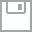
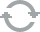
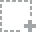
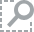
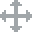
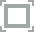
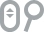
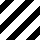
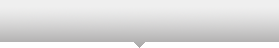
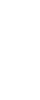
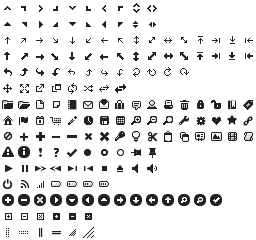
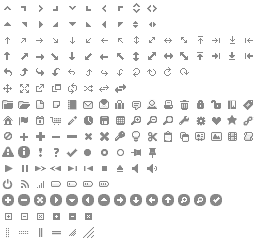
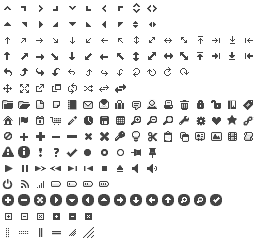
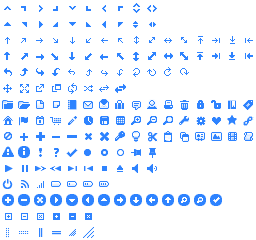
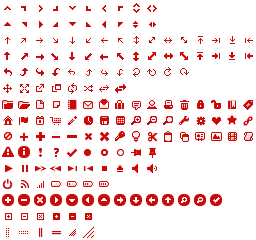
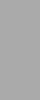
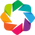
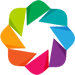

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import output_notebook, figure, show, ColumnDataSource
TOOLS="resize,crosshair,pan,wheel_zoom,box_zoom,reset,tap,previewsave,box_select,poly_select,lasso_select"
output_notebook()

In [4]:
from kmeans_aux import *

In [5]:
from sympy import *
init_printing(use_unicode=True)

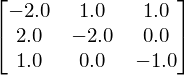

In [6]:
m = Matrix(np.matrix([[-2,1,1], [2,-2,0], [1,0,-1]]) )
m

In [7]:
X, labels_true, centres = generate_three_circles()
src = create_datasource(X, labels_true, len(centres))

In [8]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', radius='radius', color='fill_color', source=src);
show(p)

## K-Means

One possible way of recovering the categories is by using the K-Means clustering algorithm.

The $k$-means uses $k$ centroids to define clusters.
It finds the best centroids by alternating between

1. assigning data points to clusters based on the current centroids
2. chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.


### Visualization of the K-Means steps


![xxx](pics/kmeans.png)

Picture taken from [this website](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html) by Chris Piech.

1. Initialize cluster centroids $\mu_1, \mu_2, \ldots, \mu_k \in \mathcal{R}^n$ (randomly)
2. Repeat until convergence : {

    For every $i$, set $$c^{(i)} := arg \min_{j} || x^(i) - \mu_j ||^2$$

    For each $j$, set $$\mu_j := \frac{\sum_{i=1}^m 1_{c^(i) = j}x^(i) }{\sum_{i=1}^m 1_{c^(i) = j}x^(i)}$$
}

Scikit-learn already has an implementation of the algorithm

In [9]:
k_means_3_labels, k_means_3_cluster_centres = do_kmeans(X, n_clusters=3)
distance, order, is_correct = compare_kmeans_with_prior(k_means_3_cluster_centres, k_means_3_labels, centres, labels_true)

In [10]:
# part the plot
alpha = 0.9  - is_correct * 0.8
rad = src.data['radius'] * (1 + (~ is_correct * 1))
src.add(rad, 'radius2')
src.add(alpha, name='alpha' )

'alpha'

In [11]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', color='fill_color', alpha='alpha', radius='radius2', source=src);
show(p)

# Part 2: graphs

Let's assume a different dataset, with points selected from either of the following distributions.

In [12]:
X, true_labels = generate_two_moons()
p = figure(tools=TOOLS);
x,y = [list(t) for t in zip(*X)]
p.scatter(x, y, color='black', radius=0.02);
show(p)

The distribution is no longer described by centroids.

K-Means does not capture the non-linearity of the dataset structure

In [13]:
k_means_2_labels, k_means_2_cluster_centres = do_kmeans(X, n_clusters=2, n_init=10)
src2 = create_datasource(X, k_means_2_labels, len(k_means_2_cluster_centres))

In [14]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', color='fill_color', source=src2);
# alpha='alpha', radius='radius', 
show(p)

# Alternatives

#### Neural Network

#### Project the dataset into a different space (Support Vector Machine)

#### Any suggestions?




### We will look at Spectral Clustering

# Spectral Clustering

Takes only into account the local structure of the data.

Makes use of the concept of similarity, more general than that of distance.

Uses important results on the eigenvectors of the Laplacian of the similarity matrix, and clusters on a lower dimensionsional space.


### Unnormalized spectral clustering

#### Input:
- Similarity matrix $S \in R^{n \times n}$
- number $k$ of clusters to construct


#### Algorithm:
- Construct a similarity graph
$A$

- Let $W$ be its weighted adjacency matrix.

- Compute the unnormalized Laplacian
$L = D - A$

- Compute the first $k$ eigenvectors $u_1, \ldots, u_k$ of $L$

- Let $U \in R^{n \times k}$ be the matrix containing the vectors $u_1, \ldots, u_k$ as columns

- For $i = 1,\ldots, n$, let $y_i \in R^k$ be the vector corresponding to the i-th row of U
- Cluster the points $(y_i)_{i=1,\ldots,n}$ in $R^k$ with the k-means algorithm into clusters $C_1,\ldots,C_k$

#### Output:
Clusters $A_1,\ldots,A_k$ with $A_i = \{ j\, |\, y_j \in C_i\}$

## Similarity matrix / graph

Following similarity graphs can be defined

**$\epsilon-$neighborhood graph**
connects all points whose pairwise distances are smaller than $\epsilon$



**$k$-nearest neighbor graphs**
connects $v_i$ and $v_j$ if $v_j$ is among the $k$ nearest points of $k_i$


**fully connected graph**
outsources the locality modelling to the similarity function, such as
$s(x_i, x_j) = \exp\left( - \frac{|| x_i - x_j||^2}{ 2 \sigma^2} \right)$


*No full metric is required*
E.g. it is possible to compare:
- time-series based on their correlation,
- probability distributions,
- or strings on edit distance
- others


In [15]:
# Turn the distance into a similarity by applying a Gaussian kernel
distance = euclidean_distances(X, X, squared=True)

sig = 0.5

similarity = np.exp(-distance/sig)

/usr/local/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


<IPython.core.display.Javascript object>


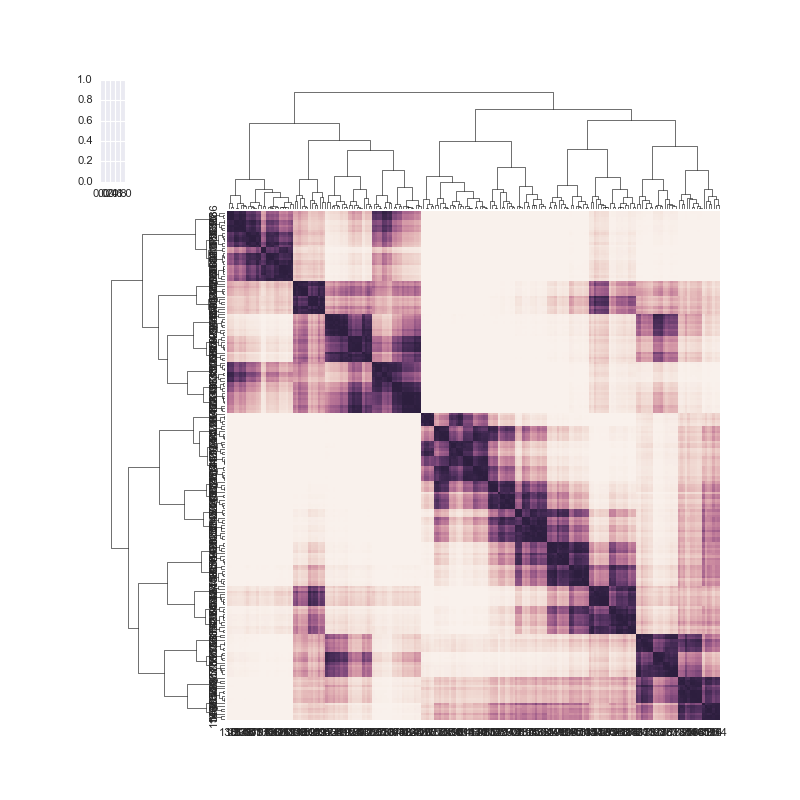

/usr/local/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [16]:
%matplotlib notebook

sns.clustermap(similarity);

In [17]:
A = create_adjacency_matrix(similarity, num_neighbours=10)

# Calculate the degree - the sum of all incoming weights to a vertex
D = np.diag(np.sum(A, axis=0))

# Unnormalised Laplacian Matrix
L = D - A

In [18]:
# Perform an Eigenvalue deccomposition of the Laplacian

from scipy.linalg import eig
[eig_vals, eig_vecs] = eig(L)

sorted_inds = np.argsort(eig_vals.real, axis=0)

In [19]:
# Perform a dimensionality reduction

k = 3
F = eig_vecs[:,sorted_inds[0:k]]

# Do k-means on the reduced space
k_means_3_labels, k_means_3_cluster_centers = do_kmeans(F, n_clusters=3)
ind_3 = np.argsort(k_means_3_labels)

In [20]:
%matplotlib notebook
plt.bar(range(10), eig_vals.real[sorted_inds[0:10]]);
# plt.imshow(similarity[ind_3].T[ind_3])

<IPython.core.display.Javascript object>

<Container object of 10 artists>

In [21]:
from networkx.generators import random_graphs
from networkx.generators import classic

In [22]:
from d3networkx import EventfulGraph, ForceDirectedGraph, empty_eventfulgraph_hook

In [23]:
def handle_graph(graph):
    print(graph.graph._sleep)
    graph_widget = ForceDirectedGraph(graph, width=1800, height=1600)
    display(graph_widget)
EventfulGraph.on_constructed(handle_graph)
random_graphs.empty_graph = empty_eventfulgraph_hook(sleep=0.01)

In [24]:
import networkx as nx
g = nx.from_numpy_matrix(A)

In [25]:
g0 = random_graphs.empty_graph()
g0.add_nodes_from(g)
for v in g.edges_iter():
    g0.add_edge(v[0], v[1])

0.01


In [26]:
ll = k_means_3_labels
ll = true_labels
for n in g0.nodes_iter():
    g0.node[n]['fill'] = '#770000' if ll[n] == 0 else '#007700' if ll[n] == 1 else '#000077'

In [27]:
# k_means_2_labels, k_means_2_cluster_centres = do_kmeans(X, n_clusters=2, n_init=10)
src3 = create_datasource(X, k_means_3_labels, len(k_means_3_cluster_centres))

In [28]:
len(k_means_3_labels)

## Results with $k=3$ clusters

In [29]:
p = figure(tools=TOOLS);
p.scatter('x', 'y', color='fill_color', source=src3);
show(p)

## Other applications

#### Outlier detection

Construct a sparse similarity graph by applying a threshold *r* on the distance.

Determine the connected components.

Outliers are components with a number of nodes smaller than a threshold *p*

![](pics/Iris_outlier_graph_small.png)

More info in 
https://github.com/dmarx/Topological-Anomaly-Detection



## Practical considerations on Spectral Clustering


### Choice of $k$
More of an art than a science. Run the algorithm with several configurations and try to minimize the 'inertia'
$$\sum_{i=0}^{n} min_{\mu_j \in C} (||x_j - \mu_i||^2)$$
, i.e. the sum of the intra-cluster distances.
The (related) concept of "silhouette" is also important.

### Choice of Laplacian
No theoretical argument for each of the versions.

### Data size
Not too many different clusters. Better for non-linear clusters.

Similarity matrix is quadratic on the number of samples... no "BigData"

It might also be helpful to perform a dimensionality reduction first with e.g. PCA.

### More info
http://www.cs.yale.edu/homes/spielman/561/2009/lect02-09.pdf


# Part 3: more graphs

Spread of risk across financial markets: better to invest in the peripheries
F. Pozzi, T. Di Matteo and T. Aste
2013, Nature Scientific Reports 3, Article number: 1665 doi:10.1038/srep01665
http://www.nature.com/srep/2013/130416/srep01665/full/srep01665.html


![xxx](pics/paper.png)


IPython notebooks and material in 
[https://github.com/mvaz/PyData2014-Berlin](https://github.com/mvaz/PyData2014-Berlin)


##  Correlation of several financial time series define a similarity matrix

The similarity is given by $a_{ij} = \sqrt{ 2(1-\sigma_{ij})}$.


![xxx](pics/method.png)


(picture taken from the paper)

## As before, the similarity matrix can be seen as a graph

Different methods for sparsifying the matrix were tested: a topological argument (Planar Maximally Filtered Graph) was used.


In this paper the authors were interested in centrality, instead of community structure.
The gist of the paper is by choosing assets in the periphery, the portfolios become more diversified.

![xxx](pics/graph.png)

(picture taken from the paper)

# Part 4: back to clouds (t-SNE)

Goal is to embedd high-dimensional objects into a lower-dimensional space (e.g. 2D).

Sophisticated modelling of the effects of the local structure onto the low dimensional embedding.

![](pics/animation.gif)

## Local structure

#### On high-dimensional space
Given a set of N high-dimensional objects $\mathbf{x}_1, \dots, \mathbf{x}_N$, t-SNE first computes probabilities $p_{ij}$ that are proportional to the similarity of objects $\mathbf{x}_i$ and $\mathbf{x}_j$, as follows:

$$p_{j|i} = \frac{\exp(-\lVert\mathbf{x}_i - \mathbf{x}_j\rVert^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-\lVert\mathbf{x}_i - \mathbf{x}_k\rVert^2 / 2\sigma_i^2)}$$,

Symmetric distance
$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$$



#### On lower-dimensional space
Heavy tailed t-Student distribution helps model dissimilar points far in a map

$$q_{ij} = \frac{(1 + \lVert \mathbf{y}_i - \mathbf{y}_j\rVert^2)^{-1}}{\sum_{k \neq l} (1 + \lVert \mathbf{y}_k - \mathbf{y}_l\rVert^2)^{-1}}$$

### Global minimization of divergence

Goal is to minimize the Kuhlback-Leibler divergence between two probability distributions


$$KL(P||Q) = \sum_{i \neq j} p_{ij} \, \log \frac{p_{ij}}{q_{ij}}$$

helps preserve local structure


### Optimization per stochastic gradient descent

The gradient turns out to be easy is easy to compute

$$
\frac{\partial \, KL(P || Q)}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) g\left( \left| x_i - x_j\right| \right) u_{ij},\\
\\
\quad \textrm{where} \, g(z) = \frac{z}{1+z^2}
$$

Here, $u_{ij}$ is a unit vector going from $y_j$ to $y_i$.
This gradient expresses the sum of all spring forces applied to map point $i$.

Adaptations to big data sets already available using the Barns Hut

# Take-home message(s)

Local methods can help reveal the structure of your data, with minor assumptions on its shape

You don't always need a distance metric. Often, a similarity function is enough, e.g.
- correlation between time series
- human label
- co-occurrence

Graph theory helps you find
- groups in your data (community detection, outlier detection)
- measure what is central

This talk is highly influenced by 

and the repository is made available in 

